In [1]:
%matplotlib inline
import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil

def reload(mName):
    import importlib
    if mName in sys.modules:
        del sys.modules[mName]
    return importlib.import_module(mName)

from collections import OrderedDict
from sklearn.preprocessing import minmax_scale
from scipy.sparse.linalg import svds
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
plt.style.use('ggplot')

utils = reload('utils.utils')
np.set_printoptions(precision=4, suppress=True, linewidth=100)
randomSeed = 88
np.random.seed(randomSeed)

<br/>
<br/>
<br/>
## Data Prepare

In [2]:
ratings = pd.read_csv("./data/ml-latest-small/ratings.csv")
movies = pd.read_csv("./data/ml-latest-small/movies.csv")
tags = pd.read_csv("./data/ml-latest-small/tags.csv")

uidEnc, midEnc = LabelEncoder(), LabelEncoder()
# encode user id and movie id to real value
midEnc.fit(movies.movieId)
uidEnc.fit(ratings.userId)

ratings["userId"] = uidEnc.transform(ratings.userId)
ratings["movieId"] = midEnc.transform(ratings.movieId)

movies["movieId"] = midEnc.transform(movies.movieId)

tags["userId"] = uidEnc.transform(tags.userId)
tags["movieId"] = midEnc.transform(tags.movieId)

midMap = pd.Series(dict(zip(movies.movieId, movies.title)))

nUsers, nMovies = len(uidEnc.classes_), len(midEnc.classes_)
print(ratings.shape)
ratings.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,0,30,2.5,1260759144
1,0,833,3.0,1260759179
2,0,859,3.0,1260759182
3,0,906,2.0,1260759185
4,0,931,4.0,1260759205


In [3]:
# movies profile
movies.head()

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy


In [4]:
# tags profile
tags.head()

,userId,movieId,tag,timestamp
0,14,304,sandra 'boring' bullock,1138537770
1,14,1517,dentist,1193435061
2,14,5166,Cambodia,1170560997
3,14,6118,Russian,1170626366
4,14,6178,forgettable,1141391765


<br/>
<br/>
<br/>
### Split Train and Test Data

In [5]:
# # 已經產生出檔案的不用跑這一段
# tr, te = utils.split_ratings(ratings, testRatio=0.3)
# tr.to_csv("./data/ml-latest-small/movielens.tr.csv", index=False)
# te.to_csv("./data/ml-latest-small/movielens.te.csv", index=False)
# utils.dumpPickle("./data/ml-latest-small/state.h", 
#         {"uidEnc": uidEnc, "midEnc": midEnc, "midMap": midMap, "nUsers": nUsers, "nMovies":nMovies})

In [6]:
tr = pd.read_csv("./data/ml-latest-small/movielens.tr.csv")
te = pd.read_csv("./data/ml-latest-small/movielens.te.csv")

state = utils.loadPickle("./data/ml-latest-small/state.h")
uidEnc, midEnc, midMap, nUsers, nMovies = \
    (state["uidEnc"], state["midEnc"], state["midMap"], state["nUsers"], state["nMovies"])

# train data rating matrix
trRatingMat = np.zeros((nUsers, nMovies))
# test data rating matrix
teRatingMat = np.zeros((nUsers, nMovies))
for idx, r in tr.iterrows():
    trRatingMat[int(r.userId), int(r.movieId)] = r.rating
for idx, r in te.iterrows():
    teRatingMat[int(r.userId), int(r.movieId)] = r.rating

print("train interaction matrix shape: ", trRatingMat.shape, "test interaction matrix shape: ", teRatingMat.shape)
print("train.shape: ", tr.shape, "test.shape: ", te.shape)
print()
print(tr.head())
print()
print(te.head())

train interaction matrix shape:  (671, 9125) test interaction matrix shape:  (671, 9125)
train.shape:  (69399, 4) test.shape:  (30605, 4)

   userId  movieId  rating   timestamp
0       0      931     4.0  1260759205
1       0     1515     4.0  1260759191
2       0       30     2.5  1260759144
3       0      833     3.0  1260759179
4       0      859     3.0  1260759182

   userId  movieId  rating   timestamp
0       0     1665     4.0  1260759139
1       0     1708     3.0  1260759194
2       0     1743     2.0  1260759198
3       0     1815     2.0  1260759108
4       0     1962     2.5  1260759113


### 以leave one out方式產生 train data, test data
```python
1. 每一筆資料有兩部分: [user query] + [item id]
2. 每一筆user query 包含所有user movie history, 除了當前的rating movie (candidate movie)
3. test data的user query來自於train data
```

In [7]:
def preprocess(data, train_hist=None, is_train=True):
    queue = []
    for u, df in data.groupby("userId"):
        df = df.sort_values("rating", ascending=False)
        if not is_train:
            user_movies_hist = train_hist.query("userId == {}".format(u)).movieId
        for i, (_, r) in enumerate(df.iterrows()):
            if is_train:
                queue.append([int(r.userId), df.movieId[:i].tolist() + df.movieId[i + 1:].tolist(), int(r.movieId), r.rating])
            else:
                all_hist = set(user_movies_hist.tolist() + df.movieId[:i].tolist())
                queue.append([int(r.userId), list(all_hist - set([int(r.movieId)])), int(r.movieId), r.rating])
    return pd.DataFrame(queue, columns=["user_id", "query_movie_ids", "candidate_movie_id", "rating"])

trProcessed = preprocess(tr)
teProcessed = preprocess(te, tr, is_train=False)
trProcessed.head()

,user_id,query_movie_ids,candidate_movie_id,rating
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",931,4.0
1,0,"[931, 1083, 833, 859, 30, 1111, 906, 1017, 104...",1515,4.0
2,0,"[931, 1515, 833, 859, 30, 1111, 906, 1017, 104...",1083,3.5
3,0,"[931, 1515, 1083, 859, 30, 1111, 906, 1017, 10...",833,3.0
4,0,"[931, 1515, 1083, 833, 30, 1111, 906, 1017, 10...",859,3.0


In [8]:
teProcessed.head()

,user_id,query_movie_ids,candidate_movie_id,rating
0,0,"[833, 931, 1083, 906, 1515, 1041, 1140, 1111, ...",1665,4.0
1,0,"[833, 1665, 931, 1083, 906, 1515, 1041, 1140, ...",1708,3.0
2,0,"[833, 1665, 931, 1083, 906, 1515, 1708, 1041, ...",2925,3.0
3,0,"[833, 1665, 906, 1041, 1111, 1047, 859, 30, 93...",1962,2.5
4,0,"[833, 1665, 906, 1041, 1111, 1047, 859, 30, 93...",1743,2.0


### Data Function
```python
1. 由於tensorflow placeholder不支援變動長度的columns, 需透過padding zero(補零)帶入
2. 每個變動長度的column, 需要再給lens描述每一筆資料的長度, ex: query_movie_ids, query_movie_ids_len
```

In [9]:
def do_multi(df, multi_cols):
    """對於multivalent的欄位, 需要增加一個column去描述該欄位的長度"""
    pad = tf.keras.preprocessing.sequence.pad_sequences
    ret = OrderedDict()
    for colname, col in df.iteritems():
        if colname in multi_cols:
            lens = col.map(len)
            ret[colname] = list(pad(col, padding="post", maxlen=lens.max()))
            ret[colname + "_len"] = lens.values
        else:
            ret[colname] = col.values
    return ret

def dataFn(data, n_batch=128, shuffle=False):
    pad = tf.keras.preprocessing.sequence.pad_sequences
    def fn():
        dataInner = data.copy()
        indices = utils.get_minibatches_idx(len(dataInner), n_batch, shuffle=shuffle)
        for ind in indices:
            yield do_multi(dataInner.iloc[ind], ["query_movie_ids"])
    return fn

for i, e in enumerate(dataFn(trProcessed, n_batch=3, shuffle=True)(), 1):
    break
pd.DataFrame(e)

,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id,rating
0,47,"[263, 2860, 3856, 6034, 2409, 2374, 7128, 5339...",357,1393,4.5
1,175,"[966, 5026, 4395, 6042, 3871, 6521, 5020, 953,...",177,4002,3.0
2,261,"[45, 1104, 154, 4514, 4171, 3801, 3727, 3644, ...",471,3089,2.0


In [10]:
class ModelMFWithHistory(object):
    def __init__(self, n_items, dim=32, learning_rate=0.01, reg=0.05, modelDir="./model/model_mf_with_history"):
        """初始化 Tensorflow Graph"""
        self.n_items = n_items
        graph = tf.Graph()
        with graph.as_default():
            with tf.variable_scope("inputs"):
                self.isTrain = tf.placeholder(tf.bool, None)
                # user data
                self.query_movie_ids = tf.placeholder(tf.int32, [None, None])
                self.query_movie_ids_len = tf.placeholder(tf.int32, [None])
                # item data
                self.candidate_movie_id = tf.placeholder(tf.int32, [None])
                # labels
                self.rating = tf.placeholder(tf.float32, [None])

            init_fn = tf.glorot_normal_initializer()
            emb_init_fn = tf.glorot_uniform_initializer()
            self.b_global = tf.Variable(emb_init_fn(shape=[]), name="b_global")
            with tf.variable_scope("embedding"):
                # embedding dictionary
                self.w_query_movie_ids = tf.Variable(emb_init_fn(shape=[self.n_items, dim]), name="w_query_movie_ids")
                self.b_query_movie_ids = tf.Variable(emb_init_fn(shape=[dim]), name="b_query_movie_ids")
                self.w_candidate_movie_id = tf.Variable(init_fn(shape=[self.n_items, dim]), name="w_candidate_movie_id")
                self.b_candidate_movie_id = tf.Variable(init_fn(shape=[dim]), name="b_candidate_movie_id")
                
                self.query_emb = tf.nn.embedding_lookup(self.w_query_movie_ids, self.query_movie_ids)
                self.candidate_emb = tf.nn.embedding_lookup(self.w_candidate_movie_id, self.candidate_movie_id)
                self.candidate_bias = tf.matmul(self.candidate_emb, self.b_candidate_movie_id[:, tf.newaxis])

            with tf.variable_scope("computation"):
                # weighted avg of query embedding
                query_emb_mask = tf.sequence_mask(self.query_movie_ids_len)
                weighted = tf.nn.l2_normalize(tf.to_float(query_emb_mask), 1)[:, :, tf.newaxis]
                self.query_emb = tf.reduce_sum(self.query_emb * weighted, 1)
                self.query_bias = tf.matmul(self.query_emb, self.b_query_movie_ids[:, tf.newaxis])
                
                infer = tf.reduce_sum(self.query_emb * self.candidate_emb, 1, keep_dims=True)
                infer = tf.add(infer, self.b_global)
                infer = tf.add(infer, self.query_bias)
                self.infer = tf.add(infer, self.candidate_bias, name="infer")
                # one query for all items
                self.pred = tf.matmul(self.query_emb, tf.transpose(self.w_candidate_movie_id)) + \
                            tf.reshape(tf.matmul(self.w_candidate_movie_id, self.b_candidate_movie_id[:, tf.newaxis]), (1, -1)) + \
                            self.query_bias + \
                            self.b_global

            with tf.variable_scope("loss"):
                self.regularizer = reg * tf.add(tf.nn.l2_loss(self.query_emb), tf.nn.l2_loss(self.candidate_emb))
                # l2_loss: Computes half the L2 norm of a tensor without the sqrt => sum(t ** 2) / 2
                # self.loss = tf.nn.l2_loss(self.infer - self.rating[:, tf.newaxis]) + self.regularizer
                self.loss = tf.losses.mean_squared_error(labels=self.rating[:, tf.newaxis], predictions=self.infer) + self.regularizer

                # for eval
                self.rmse_loss = tf.sqrt(tf.losses.mean_squared_error(labels=self.rating[:, tf.newaxis], predictions=self.infer))
                self.mae_loss = tf.reduce_mean(tf.abs(self.infer - self.rating[:, tf.newaxis]))
                pass

            with tf.variable_scope("train"):
                # self.train_op = tf.train.AdagradOptimizer(learning_rate).minimize(self.loss)
                self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
                pass

            self.saver = tf.train.Saver(tf.global_variables())
            self.graph = graph
            self.modelDir = modelDir

    def resetModel(self, modelDir):
        """刪除model dir"""
        shutil.rmtree(path=modelDir, ignore_errors=True)
        os.makedirs(modelDir)

    def feed_dict(self, data, mode="train"):
        ret = {
            self.query_movie_ids: data["query_movie_ids"],
            self.query_movie_ids_len: data["query_movie_ids_len"],
            self.candidate_movie_id: data["candidate_movie_id"]
        }
        ret[self.isTrain] = False
        if mode != "infer":
            ret[self.rating] = data["rating"]
            if mode == "train":
                ret[self.isTrain] = True
            elif mode == "eval":
                pass
        return ret

    def fit(self, sess, trainGen, testGen, reset=False, nEpoch=50):
        """model training"""
        sess.run(tf.global_variables_initializer())
        if reset:
            print("reset model: clean model dir: {} ...".format(self.modelDir))
            self.resetModel(self.modelDir)
        self.ckpt(sess, self.modelDir)

        start = time.time()
        print("%s\t%s\t%s\t%s" % ("Epoch", "Train Error", "Val Error", "Elapsed Time"))
        minLoss = 1e7
        for ep in range(1, nEpoch + 1):
            tr_loss, tr_total = 0, 0
            for i, data in enumerate(trainGen(), 1):
                loss, _ = sess.run([self.rmse_loss, self.train_op], feed_dict=self.feed_dict(data, mode="train"))
                tr_loss += loss ** 2 * len(data["query_movie_ids"])
                tr_total += len(data["query_movie_ids"])
                print("\rtrain loss: {:.3f}".format(loss), end="")
            if testGen is not None:
                epochLoss = self.epochLoss(sess, testGen)

            tpl = "\r%02d\t%.3f\t\t%.3f\t\t%.3f secs"
            if minLoss > epochLoss:
                tpl += ", saving ..."
                self.saver.save(sess, os.path.join(self.modelDir, 'model'), global_step=ep)
                minLoss = epochLoss

            end = time.time()
            print(tpl % (ep, np.sqrt(tr_loss / tr_total), epochLoss, end - start))
            start = end
        return self

    def ckpt(self, sess, modelDir):
        """load latest saved model"""
        latestCkpt = tf.train.latest_checkpoint(modelDir)
        if latestCkpt:
            self.saver.restore(sess, latestCkpt)
        return latestCkpt

    def epochLoss(self, sess, dataGen, tpe="rmse"):
        totLoss, totCnt = 0, 0
        # loss_map = {"rmse": self.rmse_loss, "mae": self.mae_loss, "target_loss": self.loss}
        for data in dataGen():
            lossTensor = self.rmse_loss if tpe == "rmse" else self.mae_loss
            loss = sess.run(lossTensor, feed_dict=self.feed_dict(data, mode="eval"))
            totLoss += (loss ** 2 if tpe == "rmse" else loss) * len(data["query_movie_ids"])
            totCnt += len(data["query_movie_ids"])
        return np.sqrt(totLoss / totCnt) if tpe == "rmse" else totLoss / totCnt

    def predict(self, sess, user_queries):
        self.ckpt(sess, self.modelDir)
        return sess.run(self.pred, feed_dict=self.feed_dict(user_queries, mode="infer"))

    def evaluateRMSE(self, sess, dataGen):
        """計算root mean square error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="rmse")

    def evaluateMAE(self, sess, dataGen):
        """計算 mean absolutely error"""
        self.ckpt(sess, self.modelDir)
        return self.epochLoss(sess, dataGen, tpe="mae")
    

learning_rate = 0.05
dim = 16
reg = 0.005
modelDir = "./model/model_mf_with_history"

tf.reset_default_graph()
model = ModelMFWithHistory(
            n_items=nMovies,
            dim=dim,
            reg=reg,
            learning_rate=learning_rate,
            modelDir=modelDir)

## Trainging

In [29]:
# 每個batch的數量
n_batch = 128
with tf.Session(graph=model.graph) as sess:
    model.fit(sess, dataFn(trProcessed, n_batch=n_batch, shuffle=True), dataFn(teProcessed, n_batch=n_batch), nEpoch=5, reset=False)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-10


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-10


Epoch	Train Error	Val Error	Elapsed Time
01	0.853		0.926		13.080 secs, saving ...
02	0.849		0.927		12.170 secs
03	0.846		0.925		14.968 secs, saving ...
04	0.844		0.926		11.942 secs
05	0.842		0.927		12.056 secs


### Another Data Function For Predict
```python
1. user_data function: 單純改變function參數, 可指定user id
```

In [11]:
def user_data(data, uids, n_batch=128):
    u_col = ["user_id", "query_movie_ids", "candidate_movie_id"]
    cache = {"u_ary": []}
    def clear(u_ary):
        u_data = do_multi(pd.DataFrame(data=u_ary, columns=u_col), ["query_movie_ids"])
        cache["u_ary"] = []
        return u_data
    
    for uid, df in data[data.user_id.isin(uids)].groupby("user_id"):
        u_rec, u_ary = df.iloc[0], cache["u_ary"]
        # print(u_rec.query_movie_ids, u_rec.candidate_movie_id)
        u_rec.set_value("query_movie_ids", u_rec.query_movie_ids + [u_rec.candidate_movie_id])
        u_ary.append(u_rec[u_col].values)
        if len(u_ary) >= n_batch:
            yield clear(u_ary)
    yield clear(u_ary)
    
for u_data in user_data(trProcessed, [0, 1], n_batch=5):
    break
pd.DataFrame(u_data)

,user_id,query_movie_ids,query_movie_ids_len,candidate_movie_id
0,0,"[1515, 1083, 833, 859, 30, 1111, 906, 1017, 10...",13,931
1,1,"[16, 129, 195, 237, 238, 9, 280, 454, 447, 427...",52,37


### 單一user rating分布圖

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
shape:  (1, 9125) [[ 0.8058  0.6409  0.5329 ...,  0.6471  0.6545  0.6671]]


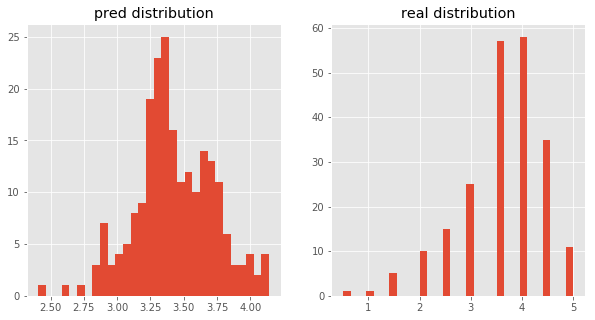

In [13]:
from sklearn.preprocessing import minmax_scale
# user id from 0 ~ 670
uid = 22
u_data = list(user_data(trProcessed, [uid], n_batch=5))[0]
with tf.Session(graph=model.graph) as sess:
    pred = model.predict(sess, u_data)
print("shape: ", pred.shape, minmax_scale(pred.T).T)

nnzCoord = teRatingMat[uid].nonzero()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("pred distribution")
pd.Series(pred.ravel()[nnzCoord]).hist(bins=30, ax=ax[0])
ax[1].set_title("real distribution")
pd.Series(map(lambda e: e, teRatingMat[uid][nnzCoord])).hist(bins=30, ax=ax[1])
plt.show()

<br/>
<br/>
<br/>
## evaluate model

In [10]:
%%time
n_batch=128
with tf.Session(graph=model.graph) as sess:
    mae_ = model.evaluateMAE(sess, dataFn(teProcessed, n_batch=n_batch))
    rmse_ = model.evaluateRMSE(sess, dataFn(teProcessed, n_batch=n_batch))

print()
print("MAE loss: ", mae_)
print("RMSE loss: ", rmse_)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9

MAE loss:  0.715391010637
RMSE loss:  0.923884173321
Wall time: 4.66 s


#### User導向評估(Recall)

In [11]:
# 可給定user id細看每個user的rating與model預測效果
# valid user id from 0 ~ 670
uid = 22
with tf.Session(graph=model.graph) as sess:
    u_data = list(user_data(trProcessed, [uid], n_batch=5))[0]
    recomm = model.predict(sess, u_data).ravel()
recommDf = pd.DataFrame(data={
              "userId": uid,
              "movieId": range(len(recomm)), 
              "title": midMap[np.arange(len(recomm))].values, 
              "rating": teRatingMat[uid, range(len(recomm))],
              "predRating": recomm},
             columns=("userId", "movieId", "title", "rating", "predRating"))
# ascending 可以調整True or False觀察結果
recommDf.query("rating != 0").sort_values("rating", ascending=False).head(50)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9


,userId,movieId,title,rating,predRating
4417,22,4417,Catch Me If You Can (2002),5.0,4.001228
5623,22,5623,Undertow (2004),5.0,3.432929
4419,22,4419,"Hours, The (2002)",5.0,3.604743
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.300426
4371,22,4371,Adaptation (2002),5.0,3.944432
4008,22,4008,And Your Mother Too (Y tu mamá también) (2001),5.0,3.722384
6132,22,6132,Crash (2004),5.0,3.763437
5016,22,5016,Stolen Kisses (Baisers volés) (1968),5.0,3.531377
5761,22,5761,Duel (1971),5.0,3.490822
4875,22,4875,"Unvanquished, The (Aparajito) (1957)",5.0,3.493510


#### Model導向評估(Precision)

In [12]:
# .query("rating != 0")
recommDf.query("rating != 0").sort_values("predRating", ascending=False).head(50)

,userId,movieId,title,rating,predRating
5127,22,5127,Eternal Sunshine of the Spotless Mind (2004),4.5,4.306888
4432,22,4432,City of God (Cidade de Deus) (2002),5.0,4.300426
4231,22,4231,Spirited Away (Sen to Chihiro no kamikakushi) ...,3.5,4.182887
4422,22,4422,"Pianist, The (2002)",4.5,4.162105
5026,22,5026,"Lord of the Rings: The Return of the King, The...",4.5,4.149228
4411,22,4411,My Neighbor Totoro (Tonari no Totoro) (1988),4.5,4.127508
6383,22,6383,V for Vendetta (2006),4.5,4.114427
6042,22,6042,Howl's Moving Castle (Hauru no ugoku shiro) (2...,3.5,4.063560
3873,22,3873,"Beautiful Mind, A (2001)",4.5,4.025702
4395,22,4395,"Lord of the Rings: The Two Towers, The (2002)",4.0,4.022087


INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3
auc: 0.745814769354


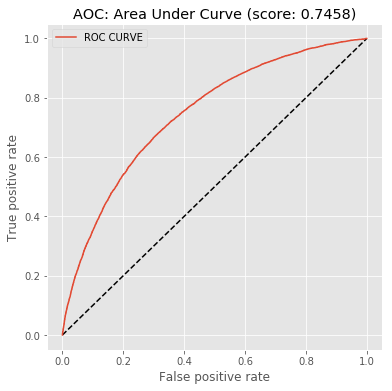

In [14]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

def drawRocCurve(y, predProba):
    fprRf, tprRf, _ = roc_curve(y, predProba, pos_label=1)
    aucScr = auc(fprRf, tprRf)
    print("auc:", aucScr)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fprRf, tprRf, label='ROC CURVE')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('AOC: Area Under Curve (score: {:.4f})'.format(aucScr))
    ax.legend(loc='best')
    plt.show()
    
coord = teRatingMat.nonzero()
with tf.Session(graph=model.graph) as sess:
    predMat = []
    for u_data in user_data(teProcessed, np.arange(nUsers), n_batch=128):
        predMat.append(model.predict(sess, u_data))
    predMat = np.vstack(predMat)
# regard rating >= 4 as user like this movie
drawRocCurve((teRatingMat[coord] >= 4).astype(int), predMat[coord])

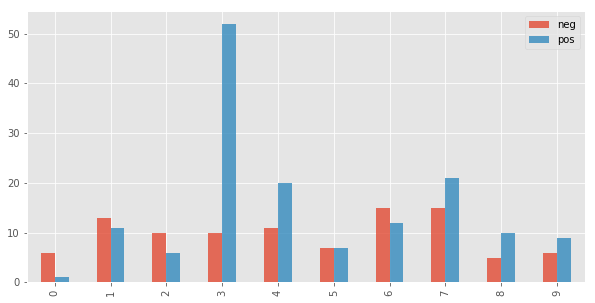

In [14]:
pos_ary, neg_ary = [], []
for label in teRatingMat:
    label = label[label != 0]
    pos_ary.append(sum(label >= 4))
    neg_ary.append(sum(label < 4))
    # print("pos: {}, neg: {}".format(sum(label >= 4), sum(label < 4)))
    
def draw_pos_neg(idx):
    pd.DataFrame(
        index=idx,
        data={"pos": np.array(pos_ary)[idx], "neg": np.array(neg_ary)[idx]}).plot.bar(figsize=(10, 5), alpha=0.8)
    plt.show()

draw_pos_neg(np.arange(len(teRatingMat))[0:10])

### About Test Data Movie Ratings(觀察上圖)
```
1. 0號, 2號, 5號, 9號 user 正向評價數量 < 10, 就算model全部預測命中, 命中率也不會是 100%!
    ex: 0號user只有1個正向評價, 全部命中也指得到0.1的分數
2. 3號user正向評價是負向評價的5倍多, 就算亂猜, 中的機率也很高
```

In [15]:
_ = sum(np.sum(teRatingMat >= 4, 1) < 10)
print("{} 個user正向評價總數小於10!".format(_))

266 個user正向評價總數小於10!


In [16]:
def strict_condition(label):
    label = label[label != 0]
    pos, neg = sum(label >= 4), sum(label < 4)
    return len(label) >= 10 and pos <= neg and pos > 0
    
print("rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [{}] 人".format(sum(strict_condition(label) for label in teRatingMat)))

def norm_condition(label):
    label = label[label != 0]
    return sum(label >= 4) > 0 and sum(label < 4) > 0

print("rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [{}] 人".format(sum(norm_condition(label) for label in teRatingMat)))

rating數量 >= 10 且 負評價數量 >= 正評價數量 有 [209] 人
rating正評價數量 >= 0 且 rating負評價數量 >= 0 有 [669] 人


#### Precision At K: 
> **預測分數高(rating >= 4)的前10部電影, 和實際user rating比較, 觀察命中率**

In [17]:
%%time
from sklearn.metrics import precision_score

def precision_at_k(truth, pred_mat, condition_fn=None, k=10, label_thres=4):
    hits, total = 0, 0
    for label, pr in zip(truth, pred_mat):
        if not condition_fn(label): continue

        top_k_ind = (pr * (label != 0)).argsort()[::-1][:k]
        hits += sum(label[top_k_ind] >= label_thres)
        total += k
    return hits / total

with tf.Session(graph=model.graph) as sess:
    pred_mat= []
    for u_data in user_data(trProcessed, np.arange(nUsers), n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data))
    pred_mat = np.vstack(pred_mat)
    
print( "strict condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, strict_condition, k=10) )
print( "norm condition precision at 10: ", precision_at_k(teRatingMat, pred_mat, norm_condition, k=10) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
strict condition precision at 10:  0.505741626794
norm condition precision at 10:  0.629895366218
Wall time: 1.24 s


### NDCG: Normalized Discounted Cumulative Gain
1. A measure of ranking quality.
2. loop 每一位user, prediciton score排序後計算NDCG
    <br/>$$ DCG_p = \sum^p_{i = 1} \frac{2^{rel_i} - 1}{log_2(i + 1)} $$<br/>
3. IDCG: Ideal DCG, 為理想狀態下的DCG分數, 即model全部命中的DCG分數, 而NDCG: Normalized DCG, 公式如下
    <br/>$$ NDCG_p = \sum^p_{i = 1} \frac{DCG_p}{IDCG_p} $$<br/>
4. 所以NDCG是一個比值, 介於0 ~ 1之間

In [18]:
def single_user_ndcg(label, score, label_thres=4, k=10):
    """single user ndcg score"""
    nnz = label.nonzero()[0]
    # if np.sum(label >= label_thres) < k: return None
    label, score = label[nnz], score[nnz]
    label = (label >= label_thres).astype(int)
    return utils.ndcg_score(label, score, k)

def all_user_ndcg(label, pred_mat, cond_fn, label_thres=4, k=10):
    """avg of all user ndcg score"""
    tot_ndcg, actual_cnt = 0, 0
    for i, (label, score) in enumerate(zip(teRatingMat, pred_mat)):
        if not cond_fn(label): continue

        ndcg = single_user_ndcg(label, score, k=10)
        if ndcg is not None:
            tot_ndcg += ndcg
            actual_cnt += 1
    return tot_ndcg / actual_cnt

with tf.Session(graph=model.graph) as sess:
    pred_mat= []
    for u_data in user_data(trProcessed, np.arange(nUsers), n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data))
    pred_mat = np.vstack(pred_mat)
    
strict_ndcg = all_user_ndcg(teRatingMat, pred_mat, strict_condition, label_thres=4, k=10)
norm_ndcg = all_user_ndcg(teRatingMat, pred_mat, norm_condition, label_thres=4, k=10)
print("strict condition ndcg at 10: ", strict_ndcg)
print("norm condition ndcg at 10: ", norm_ndcg)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
strict condition ndcg at 10:  0.626024889489
norm condition ndcg at 10:  0.755816306572


#### Recall At K: 
> **對於每個user喜歡的前10部電影中(rating >= 4), 和預測值比較, 觀察命中率**

In [19]:
%%time
from sklearn.metrics import recall_score

def recall_at_k(truth, pred_mat, condition_fn, k=10, label_thres=4, pred_thres=0.8):
    hits, total = 0, 0
    for labels, pr in zip(truth, pred_mat):
        if not condition_fn(labels): continue

        top_percentile = np.percentile(pr, pred_thres * 100)
        top_k_ind = labels.argsort()[::-1][:k]
        hits += sum(pr[top_k_ind] >= top_percentile)
        # hits += recall_score(labels >= label_thres, pr >= np.percentile(pr, pred_thres * 100))
        total += k
    return hits / total

with tf.Session(graph=model.graph) as sess:
    pred_mat= []
    for u_data in user_data(trProcessed, np.arange(nUsers), n_batch=n_batch):
        pred_mat.append(model.predict(sess, u_data))
    pred_mat = np.vstack(pred_mat)
    
def recall_cond_fn(label):
    """recall條件限制為, user在test data正向評價電影至少10部"""
    return sum(label >= 4) >= 10
    
print( recall_at_k(teRatingMat, pred_mat, condition_fn=recall_cond_fn) )

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-9
0.570617283951
Wall time: 15.3 s


<br/>
<br/>
<br/>
## 取出movies embedding, 使用cosine similarity列出最相似的電影

In [15]:
movies[movies.title.str.contains("Toy")]

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1579,1579,Babes in Toyland (1961),Children|Fantasy|Musical
1780,1780,Toys (1992),Comedy|Fantasy
2479,2479,Babes in Toyland (1934),Children|Comedy|Fantasy|Musical
2506,2506,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3829,3829,"Toy, The (1982)",Comedy
4341,4341,Toy Soldiers (1991),Action|Drama
7556,7556,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
8437,8437,Toy Story of Terror (2013),Animation|Children|Comedy


In [16]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def most_like(model, seed_movie, k=10):
    """給定某一部電影, 使用model裡movies embedding找尋cosine相似度高的其他電影!"""
    with tf.Session(graph=model.graph) as sess:
        model.ckpt(sess, model.modelDir)
        movie_emb = sess.run(model.candidate_emb, feed_dict={model.candidate_movie_id: movies.movieId.values})
        
    most_like = cosine_similarity(movie_emb[seed_movie][np.newaxis, :], movie_emb).ravel().argsort()[::-1][:k]
    return movies.iloc[most_like]

most_like(model, 0, k=10)

INFO:tensorflow:Restoring parameters from ./model/model_mf_with_history\model-3


,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
954,954,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1052,1052,"Killing Fields, The (1984)",Drama|War
961,961,Lawrence of Arabia (1962),Adventure|Drama|War
321,321,Forrest Gump (1994),Comedy|Drama|Romance|War
743,743,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
6706,6706,Once (2006),Drama|Musical|Romance
974,974,"Killer, The (Die xue shuang xiong) (1989)",Action|Crime|Drama|Thriller
966,966,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2212,2212,"Sixth Sense, The (1999)",Drama|Horror|Mystery
